# PLAN

- [x] Acquisition
    - [x] Select what list of repos to scrape.
    - [x] Get requests form the site.
    - [x] Save responses to csv.
- [ ] Preparation
    - [x] Prepare the data for analysis.
- [ ] Exploration
    - [ ] Answer the following prompts:
        - [ ] What are the most common words in READMEs?
        - [ ] What does the distribution of IDFs look like for the most common words?
        - [ ] Does the length of the README vary by language?
        - [ ] Do different languages use a different number of unique words?
- [ ] Modeling
    - [ ] Transform the data for machine learning; use language to predict.
    - [ ] Fit several models using different text repressentations.
    - [ ] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [ ] Documentation within the notebook.
        - [ ] README file in the repo.
        - [ ] Python scripts if applicable.
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [394]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

import unicodedata
import re
from requests import get
import json
# import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import pandas as pd
import time
import csv
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Global variables holding all of our language names and additional stopwords
LANGUAGES = ['JavaScript', 'Rust', 'C++', 'Python', 'Dart', 'Java', 'Go', 'CSS',
             'PHP', 'TypeScript', 'Ruby', 'HTML', 'C', 'Vue', 'C#', 'Shell',
             'Clojure', 'Objective-C', 'Swift', 'Jupyter Notebook','Vim script',
             'Assembly', 'Kotlin', 'Dockerfile', 'TeX', 'javascript', 'rust',
             'c++', 'python', 'dart', 'java', 'go', 'css', 'php', 'typescript',
             'ruby', 'html', 'c', 'vue', 'c#', 'shell', 'clojure', 'objective-c',
             'swift', 'jupyter notebook', 'vim script', 'assembly', 'kotlin',
             'dockerfile', 'tex', 'yes', 'one', 'also', 'two', 'etc', 'please']

BASEURL = 'https://github.com/search?p=1&q=stars%3A%3E0&s=stars&type=Repositories'
HEADERS = {'User-Agent': 'Assault Potato Gun'}

# ACQUIRE

First thing that needs to happen is to get the links from the most starred github repositories.  The most complicated part here was identifying the section that had the actual urls.

The `get_url_list` function does the following:
* get a response from the BASEURL
* set number of pages to scrape and loop through all of them
* find the list of all the repos on the page
* from that list find the individual list item repos
* do a check to see if there is a language associated with the repo
* * if no language, skip
* loop through individual repo sections and grab the url
* print out a list of the total valid urls scraped
* save the resulting list of urls to a csv
* return the urls

In [395]:
def get_url_list(page):
    urls = []
    response = get(BASEURL, headers=HEADERS)
    soup = BeautifulSoup(response.content)
    max_page = page + 1
    for i in range(120,max_page):
        url = 'https://github.com/search?p=' + str(i) + '&q=stars%3A%3E0&s=stars&type=Repositories'
        print(f'traversing url: {url}')
        response = get(url, headers=HEADERS)
        soup = BeautifulSoup(response.text)
        list_of_repos = soup.find('ul', class_='repo-list')
        repository = list_of_repos.find_all('li', class_='repo-list-item')
        for h in repository:
            if h.find(attrs={'itemprop':'programmingLanguage'}):
                a = h.find('a')
                urls.append(a.attrs['href'])
        time.sleep(8)
    print(f'Scraped a total of {len(urls)} github urls.')
    urls = ['https://github.com' + url for url in urls]
    with open('github_urls7.csv', 'a') as f:
        ghub_urls = csv.writer(f, delimiter=',')
        ghub_urls.writerow(urls)
    return urls


In [397]:
get_url_list(131)

traversing url: https://github.com/search?p=120&q=stars%3A%3E0&s=stars&type=Repositories


AttributeError: 'NoneType' object has no attribute 'find_all'

Now that we have the list of urls from `get_url_list`, we need to do the following:
* visit each of the urls
* find the main body of the `README.md`
* * if there is no body in the `README.md` then skip it
* grab the readme info
* find the prominent language and grab that as well
* do this for all the urls in the list from the previous function

In [286]:
def grab_readmes_and_languages(urls):
    readmes = []
    languages = []
    for url in urls:
        response = get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        if soup.find('div', class_='Box-body') == None:
            continue
        else:
            single_readme = soup.find('div', class_='Box-body').text
        if soup.find('span', class_='lang') == None:
            continue
        else:
            repo_language = soup.find('span', class_='lang').text
        languages.append(repo_language)
        readmes.append(single_readme)
        time.sleep(5)
    df = pd.DataFrame({'readme':readmes, 'language':languages})
    return df

Now that we have a big bunch of words and languages in a dataframe, we need to do some cleanup.  These functions will do the following:
* lowercase all the text
* normalize the language into english-only
* only keep words that start with letters, numbers, or whitespace
* strip any whitespace at the start or the end of a word
* replace any newlines with a space
* tokenize the words
* either stem or lemmatize the words
* remove all standard stopwords as well as the languages and any additional stopwords that were found during exploration

In [345]:
def basic_clean(string):
    """Will lowercase, normalize, and remove anything that isn't a letter, number,
    whitespace or single quote and return it."""
    clean_string = string.lower()
    clean_string = unicodedata.normalize('NFKD', clean_string).\
                    encode('ascii', 'ignore').\
                    decode('utf-8', 'ignore')
    clean_string = re.sub(r'[^a-z0-9\s]', '', clean_string)
    clean_string = clean_string.strip()
    clean_string = re.sub(r'\s+', ' ', clean_string)
    return clean_string

def tokenize(string, string_or_list='string'):
    """nltk.tokenize.ToktokTokenizer"""
    tokenizer = nltk.tokenize.ToktokTokenizer()
    if string_or_list == 'string':
        return tokenizer.tokenize(string, return_str=True)
    if string_or_list == 'list':
        return tokenizer.tokenize(string)
    
def stem(string, string_or_list='string'):
    """Returns the stems."""
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    stemmed_string = ' '.join(stems)
    if string_or_list == 'list':
        return stems
    if string_or_list == 'string':
        return stemmed_string
    
def lemmatize(string, string_or_list='string'):
    """Returns the lemmatized text."""
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    lemmatized_string = ' '.join(lemmas)
    if string_or_list == 'string':
        lemmatized_string = re.sub(r'(^| ).( |$)', '', lemmatized_string)
        lemmatized_string = re.sub(r'(^| )[0-9]( |$)', '', lemmatized_string)        
        
        return lemmatized_string
    if string_or_list == 'list':
        return lemmas
    
def remove_stopwords(string, string_or_list='string', extra_words=None, exclude_words=None):
    """Removes the stopwords from the text then returns it. Able to add or remove stopwords."""
    stopword_list = stopwords.words('english') + LANGUAGES
    if extra_words != None:
        for word in extra_words:
            stopword_list.append(word)
    if exclude_words != None:
        for word in exclude_words:
            stopword_list.remove(word)
    filtered_words = [word for word in string.split() if word not in stopword_list]
    filtered_string = ' '.join(filtered_words)
    if string_or_list == 'string':
        return filtered_string
    if string_or_list == 'list':
        return filtered_words
    
def remove_languages(string, string_or_list='string', extra_words=None, exclude_words=None):
    """Removes the stopwords from the text then returns it. Able to add or remove stopwords."""
    stopword_list = stopwords.words('english') + languages
    if extra_words != None:
        for word in extra_words:
            stopword_list.append(word)
    if exclude_words != None:
        for word in exclude_words:
            stopword_list.remove(word)
    filtered_words = [word for word in string.split() if word not in stopword_list]
    filtered_string = ' '.join(filtered_words)
    if string_or_list == 'string':
        return filtered_string
    if string_or_list == 'list':
        return filtered_words

# fancy pipe function
def pipe(v, *fns):
    return reduce(lambda x, f: f(x), fns, v)

def readme_lem(text):
    return pipe(text, basic_clean, tokenize, remove_stopwords, lemmatize)

def readme_stem(text):
    return pipe(text, basic_clean, tokenize, remove_stopwords, stem)

If we already have the urls, we don't need to re-scrape them.

In [270]:
with open('github_urls.csv') as f:
    urls = f.readlines()
urls = urls[0].split(',')

with open('github_urls1.csv') as f:
    urls2 = f.readlines()
urls2 = urls2[0].split(',')

with open('github_urls3.csv') as f:
    urls3 = f.readlines()
urls3 = urls3[0].split(',')

with open('github_urls4.csv') as f:
    urls4 = f.readlines()
urls4 = urls4[0].split(',')

with open('github_urls5.csv') as f:
    urls5 = f.readlines()
urls5 = urls5[0].split(',')

with open('github_urls6.csv') as f:
    urls6 = f.readlines()
urls6 = urls6[0].split(',')

In [274]:
url_list = [urls, urls2, urls3, urls4, urls5, urls6]

In [289]:
len(urls)

723

In [291]:
df = grab_readmes_and_languages(urls)

KeyboardInterrupt: 

To keep us from having to rescrape, save the dataframe to a csv.

In [292]:
df.shape

(719, 2)

In [293]:
df.to_csv('github_data_719.csv', index=False)

In [347]:
df = pd.read_csv('github_data_719.csv')
df.head(10)

,readme,language
0,\n\n\n\nMarked\n\n\n\n\n\n\n\n\n\n⚡ built for ...,JavaScript
1,\nNetty Project\nNetty is an asynchronous even...,Java
2,"\nReact Starter Kit — ""isomorphic"" web app boi...",JavaScript
3,"\nUppy\n\n\n\nUppy is a sleek, modular JavaScr...",JavaScript
4,\nparticles.js\nA lightweight JavaScript libra...,JavaScript
5,\nYouCompleteMe: a code-completion engine for ...,Python
6,\n\n \n\nDrag and drop so simple it hurts\n\...,JavaScript
7,\nNProgress\n\n\n\n\nMinimalist progress bar\n...,JavaScript
8,\nAwesome - Most Cited Deep Learning Papers\n\...,TeX
9,\nprofile-summary-for-github\nlive at https://...,Kotlin


# PREPARE

Create new columns in our dataframe that have the lemmatized and stemmed text while keeping original text intact.

In [348]:
df['lemmatized'] = df.readme.apply(readme_lem)

In [349]:
df['stemmed'] = df.readme.apply(readme_stem)

In [350]:
df.head()

,readme,language,lemmatized,stemmed
0,\n\n\n\nMarked\n\n\n\n\n\n\n\n\n\n⚡ built for ...,JavaScript,marked built speed lowlevel compiler parsing m...,mark built speed lowlevel compil pars markdown...
1,\nNetty Project\nNetty is an asynchronous even...,Java,netty project netty asynchronous eventdriven n...,netti project netti asynchron eventdriven netw...
2,"\nReact Starter Kit — ""isomorphic"" web app boi...",JavaScript,react starter kit isomorphic web app boilerpla...,react starter kit isomorph web app boilerpl re...
3,"\nUppy\n\n\n\nUppy is a sleek, modular JavaScr...",JavaScript,uppy uppy sleek modular file uploader integrat...,uppi uppi sleek modular file upload integr sea...
4,\nparticles.js\nA lightweight JavaScript libra...,JavaScript,particlesjs lightweight library creating parti...,particlesj lightweight librari creat particl d...


List of how many blocks of text we have by language.  We decided to drop all but the top 9.

In [351]:
df.language.value_counts()

JavaScript          294
Python               95
Java                 58
Go                   46
C++                  38
HTML                 23
C                    23
TypeScript           17
CSS                  16
Kotlin               15
Vue                  12
Ruby                 12
Shell                10
Swift                10
PHP                   7
Dart                  6
TeX                   6
Rust                  6
Jupyter Notebook      5
Clojure               3
Dockerfile            3
C#                    3
Vim script            3
Assembly              3
Objective-C           3
Batchfile             1
Rascal                1
Name: language, dtype: int64

Word count of just JavaScript

In [352]:
pd.Series(' '.join(df[df.language == 'JavaScript'].lemmatized).split()).value_counts()

use                                                 3586
code                                                3459
const                                               3280
function                                            3170
source                                              2843
react                                               2646
native                                              2450
return                                              2189
using                                               2116
example                                             2069
file                                                1860
top                                                 1796
object                                              1609
new                                                 1562
back                                                1555
value                                               1504
element                                             1348
true                           

In [353]:
df.language.value_counts()[:9].index

Index(['JavaScript', 'Python', 'Java', 'Go', 'C++', 'HTML', 'C', 'TypeScript',
       'CSS'],
      dtype='object')

In [354]:
languages_to_keep = df.language.value_counts()[:9].index
languages_to_keep

Index(['JavaScript', 'Python', 'Java', 'Go', 'C++', 'HTML', 'C', 'TypeScript',
       'CSS'],
      dtype='object')

In [355]:
df2 = df[df.language.isin(languages_to_keep)]
df2.head()

,readme,language,lemmatized,stemmed
0,\n\n\n\nMarked\n\n\n\n\n\n\n\n\n\n⚡ built for ...,JavaScript,marked built speed lowlevel compiler parsing m...,mark built speed lowlevel compil pars markdown...
1,\nNetty Project\nNetty is an asynchronous even...,Java,netty project netty asynchronous eventdriven n...,netti project netti asynchron eventdriven netw...
2,"\nReact Starter Kit — ""isomorphic"" web app boi...",JavaScript,react starter kit isomorphic web app boilerpla...,react starter kit isomorph web app boilerpl re...
3,"\nUppy\n\n\n\nUppy is a sleek, modular JavaScr...",JavaScript,uppy uppy sleek modular file uploader integrat...,uppi uppi sleek modular file upload integr sea...
4,\nparticles.js\nA lightweight JavaScript libra...,JavaScript,particlesjs lightweight library creating parti...,particlesj lightweight librari creat particl d...


In [356]:
pd.Series(' '.join(df2.lemmatized).split()).value_counts().reset_index()

,index,0
0,use,5491
1,code,5090
2,source,4270
3,file,4092
4,library,3852
5,data,3842
6,function,3761
7,using,3685
8,const,3304
9,example,3017


Looking at the percentage of words by language.

In [357]:
lang = pd.concat([df2.language.value_counts(),
                    df2.language.value_counts(normalize=True)], axis=1)
lang.columns = ['n', 'percent']
lang

,n,percent
JavaScript,294,0.481967
Python,95,0.155738
Java,58,0.095082
Go,46,0.075410
C++,38,0.062295
C,23,0.037705
HTML,23,0.037705
TypeScript,17,0.027869
CSS,16,0.026230


# EXPLORE

Breaking up the words into separate variables by language.

In [358]:
javascript_words = ' '.join(df2[df2.language == 'JavaScript']['lemmatized'])
python_words = ' '.join(df2[df2.language == 'Python']['lemmatized'])
java_words = ' '.join(df2[df2.language == 'Java']['lemmatized'])
go_words = ' '.join(df2[df2.language == 'Go']['lemmatized'])
cpp_words = ' '.join(df2[df2.language == 'C++']['lemmatized'])
c_words = ' '.join(df2[df2.language == 'C']['lemmatized'])
html_words = ' '.join(df2[df2.language == 'HTML']['lemmatized'])
typescript_words = ' '.join(df2[df2.language == 'TypeScript']['lemmatized'])
css_words = ' '.join(df2[df2.language == 'CSS']['lemmatized'])
all_words = ' '.join(df2['lemmatized'])

In [359]:
pd.Series(javascript_words.split()).value_counts()

use                                                 3586
code                                                3459
const                                               3280
function                                            3170
source                                              2843
react                                               2646
native                                              2450
return                                              2189
using                                               2116
example                                             2069
file                                                1860
top                                                 1796
object                                              1609
new                                                 1562
back                                                1555
value                                               1504
element                                             1348
true                           

Frequency of words by language

In [360]:
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
cpp_freq = pd.Series(cpp_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
typescript_freq = pd.Series(typescript_words.split()).value_counts()
css_freq = pd.Series(css_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [361]:
python_freq.head()

data        2064
library     1940
unknown     1611
learning    1492
file        1367
dtype: int64

In [362]:
word_counts = (pd.concat([all_freq, javascript_freq, python_freq, java_freq, go_freq,
                         cpp_freq, c_freq, html_freq, typescript_freq, css_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'python', 'java', 'go', 'cpp', 'c',
                           'html', 'typescript', 'css'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='java', ascending=False)

,all,javascript,python,java,go,cpp,c,html,typescript,css
license,1337,572,87,185,246,100,72,39,1,35
use,5491,3586,1026,129,370,136,89,102,18,35
spring,165,24,6,123,0,0,12,0,0,0
algorithm,902,219,458,123,90,0,0,12,0,0
time,1422,647,376,117,165,16,48,41,3,9
example,3017,2069,503,116,222,49,15,26,5,12
dependency,729,330,99,116,117,19,33,9,3,3
type,1366,599,309,112,276,16,45,3,6,0
node,633,309,99,111,75,12,6,15,3,3
index,489,265,105,99,6,1,7,6,0,0


Text(0.5, 1.0, 'Proportion of JavaScript vs All for the 20 most common words')

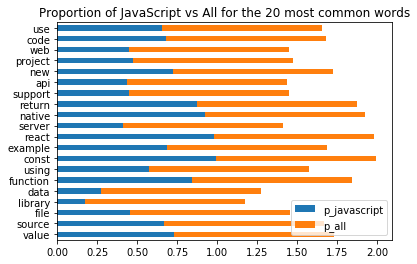

In [363]:
# figure out the percentage of javascript vs all
(word_counts
 .assign(p_javascript=word_counts.javascript / word_counts['all'],
         p_all=word_counts['all'] / word_counts['all'])
 .sort_values(by='all')
 [['p_javascript', 'p_all']]
 .tail(20)
 .sort_values('p_all')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs All for the 20 most common words')

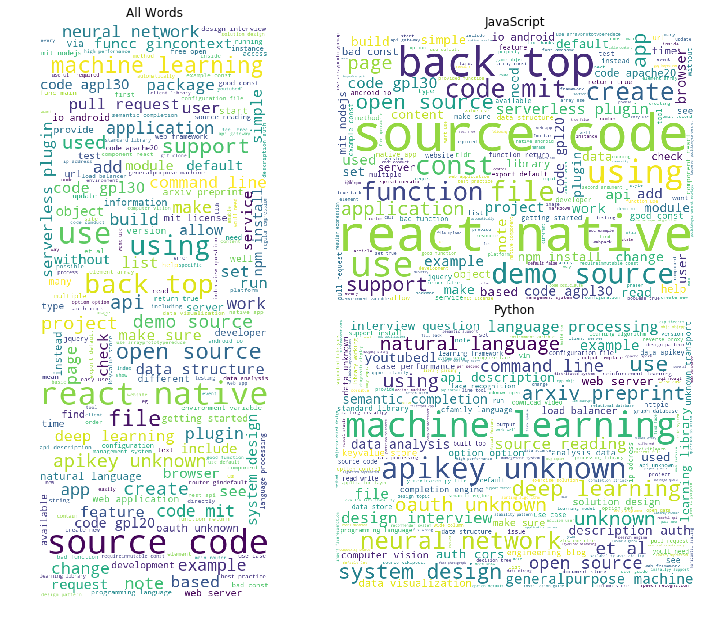

In [364]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(''.join(all_words))
javascript_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(javascript_words))
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(python_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(javascript_cloud)
axs[2].imshow(python_cloud)

axs[0].set_title('All Words')
axs[1].set_title('JavaScript')
axs[2].set_title('Python')

for ax in axs: ax.axis('off')

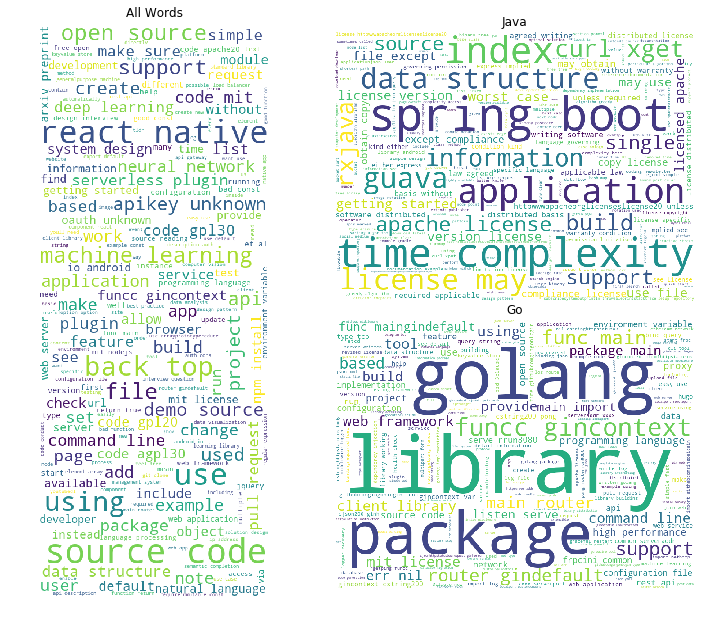

In [365]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(''.join(all_words))
java_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(java_words))
go_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(go_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(java_cloud)
axs[2].imshow(go_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Java')
axs[2].set_title('Go')

for ax in axs: ax.axis('off')

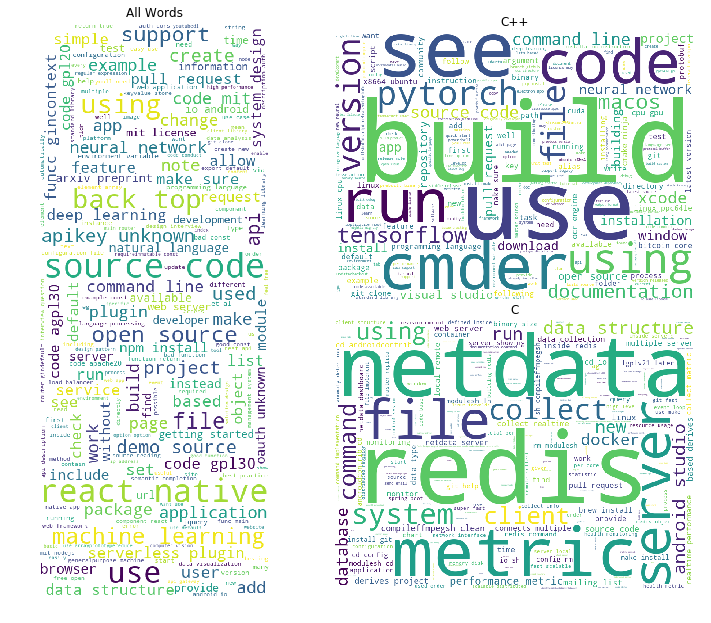

In [366]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(''.join(all_words))
cpp_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(cpp_words))
c_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(c_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(cpp_cloud)
axs[2].imshow(c_cloud)

axs[0].set_title('All Words')
axs[1].set_title('C++')
axs[2].set_title('C')

for ax in axs: ax.axis('off')

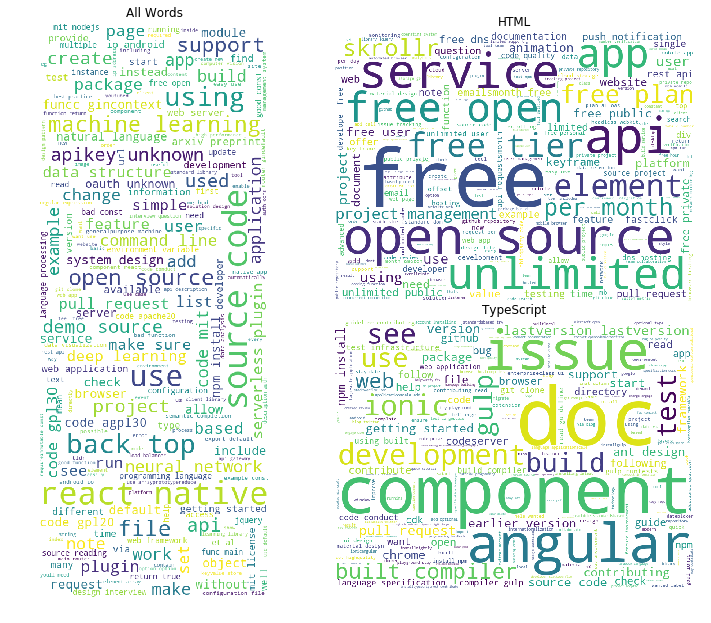

In [367]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(''.join(all_words))
html_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(html_words))
typescript_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(typescript_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(html_cloud)
axs[2].imshow(typescript_cloud)

axs[0].set_title('All Words')
axs[1].set_title('HTML')
axs[2].set_title('TypeScript')

for ax in axs: ax.axis('off')

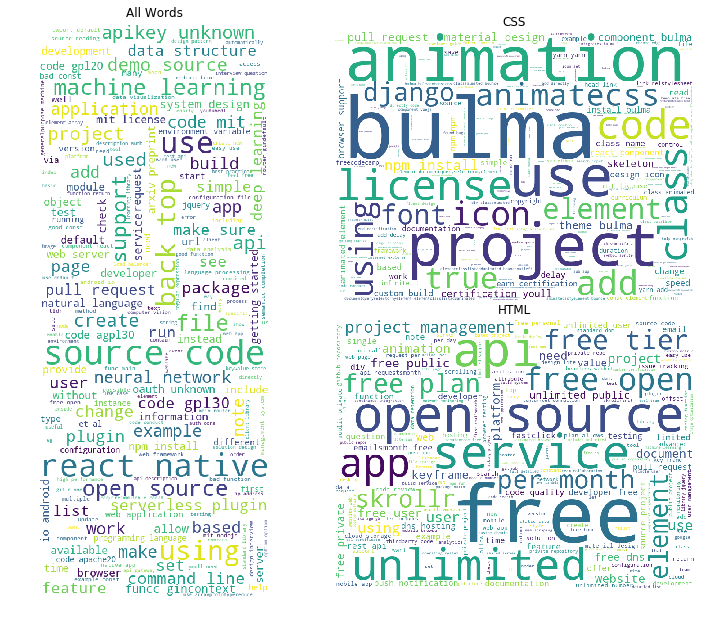

In [368]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(''.join(all_words))
css_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(css_words))
html_cloud = WordCloud(background_color='white', height=600, width=800).generate(''.join(html_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(css_cloud)
axs[2].imshow(html_cloud)

axs[0].set_title('All Words')
axs[1].set_title('CSS')
axs[2].set_title('HTML')

for ax in axs: ax.axis('off')

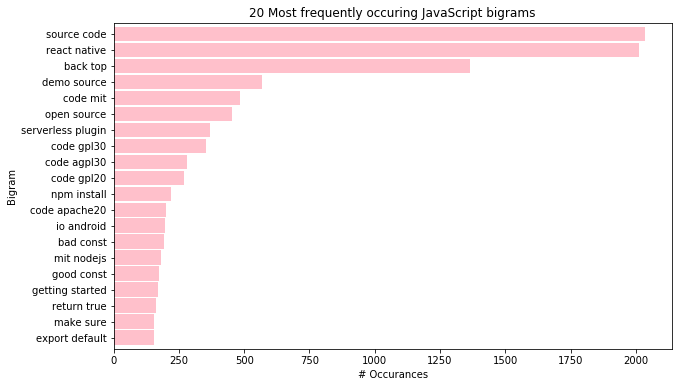

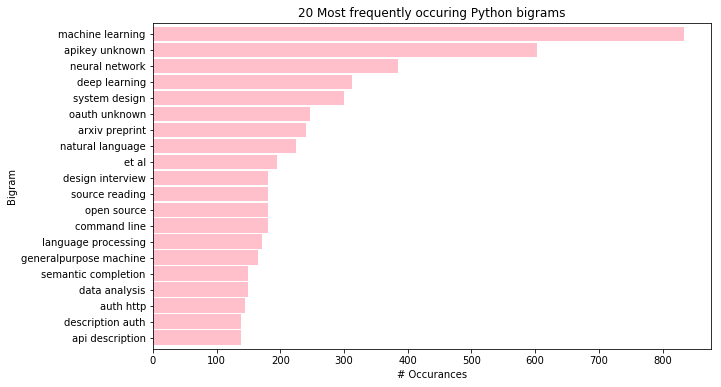

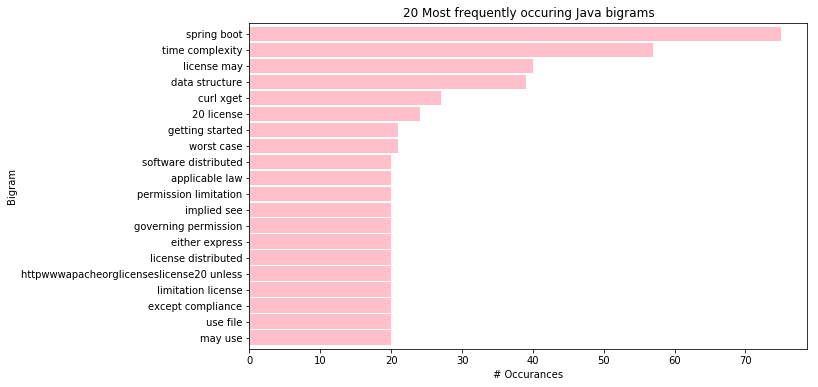

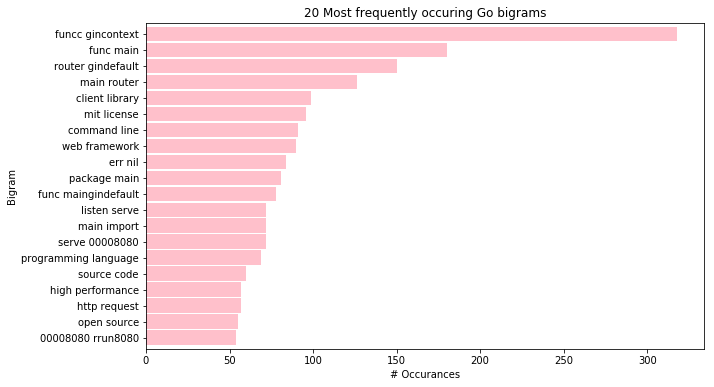

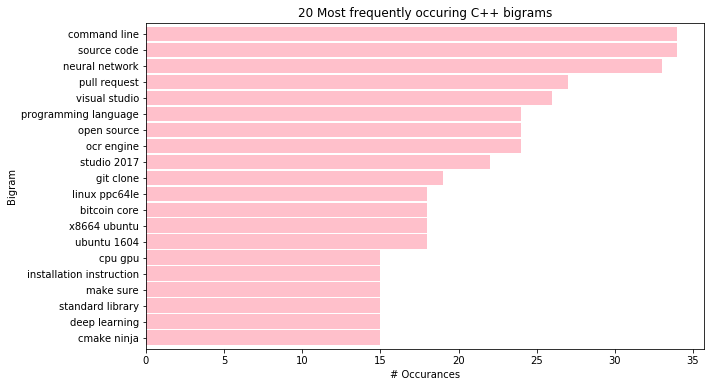

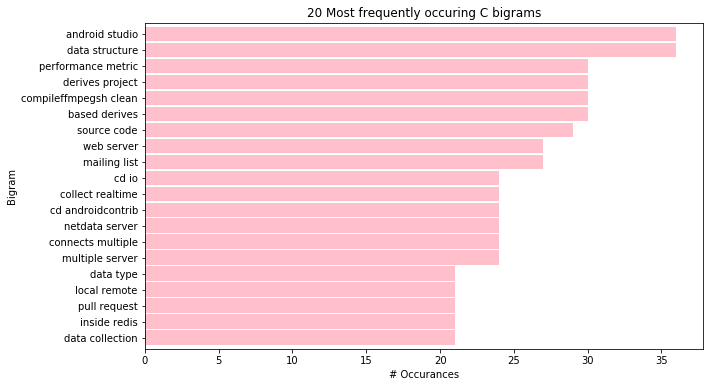

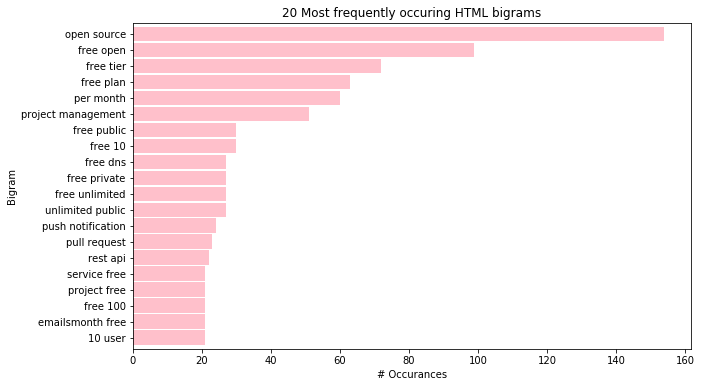

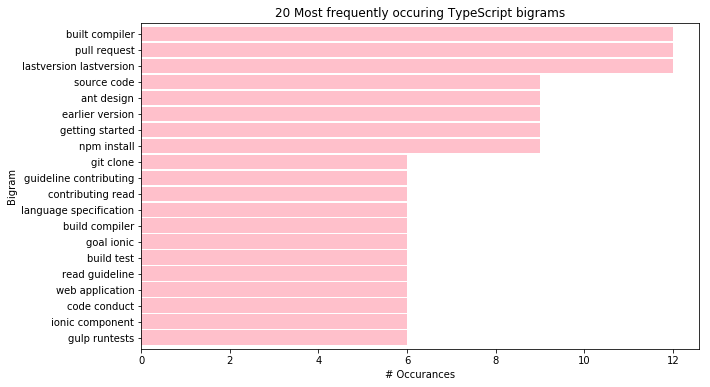

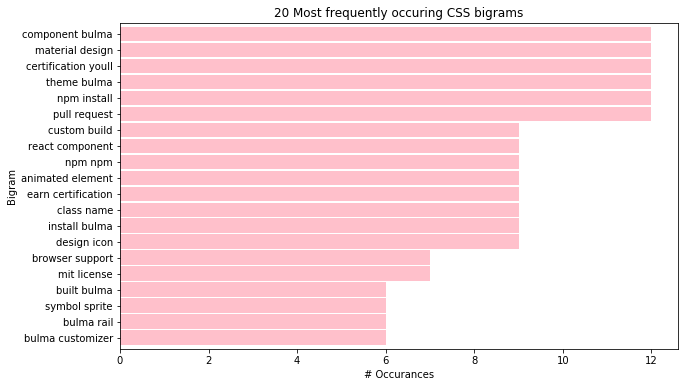

In [369]:
x=0
lang_words = [javascript_words, python_words, java_words, go_words, cpp_words, c_words, html_words, 
          typescript_words, css_words]
lang_list = ['JavaScript', 'Python', 'Java', 'Go', 'C++', 'C', 'HTML', 'TypeScript', 'CSS']

for i in lang_words:
    gram = (pd.Series(nltk.ngrams(i.split(), 2))
                          .value_counts()
                          .head(20))
    l = lang_list
    gram.head()

    gram.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))
    
    
    plt.title(f'20 Most frequently occuring {l[x]} bigrams')
    x += 1
    plt.ylabel('Bigram')
    plt.xlabel('# Occurances')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = gram.reset_index().sort_values(by=0)['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)
    plt.show()

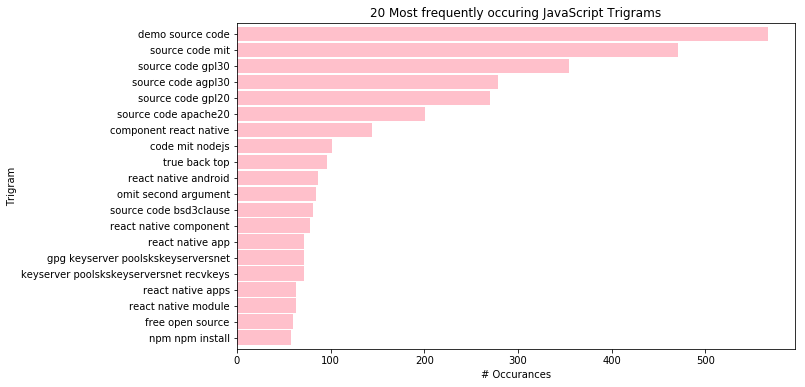

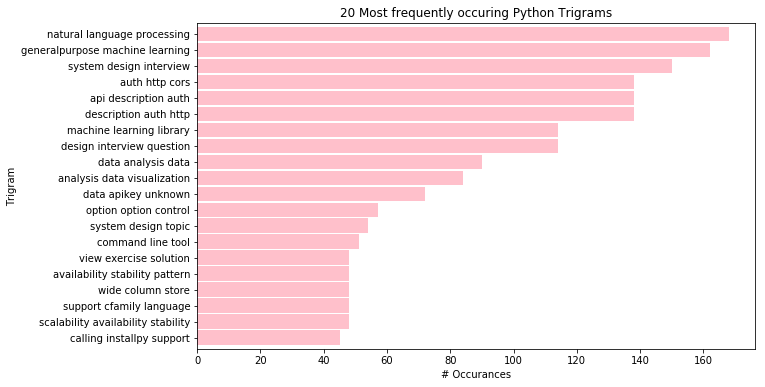

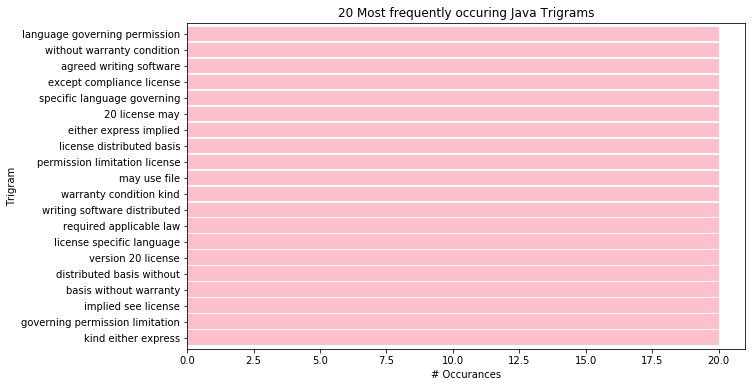

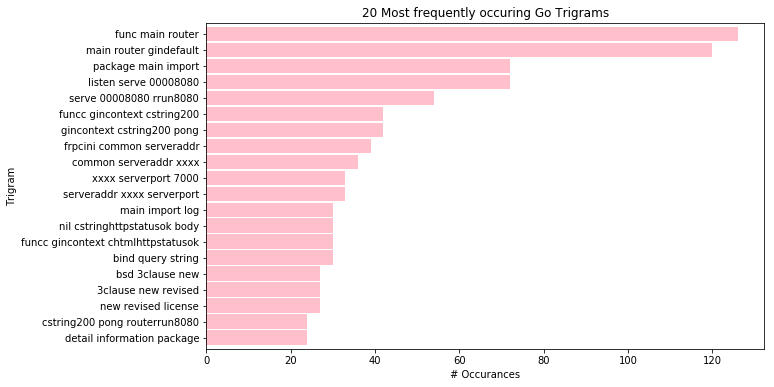

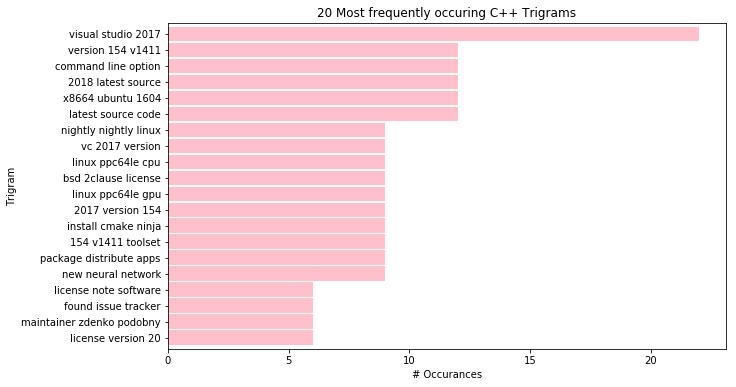

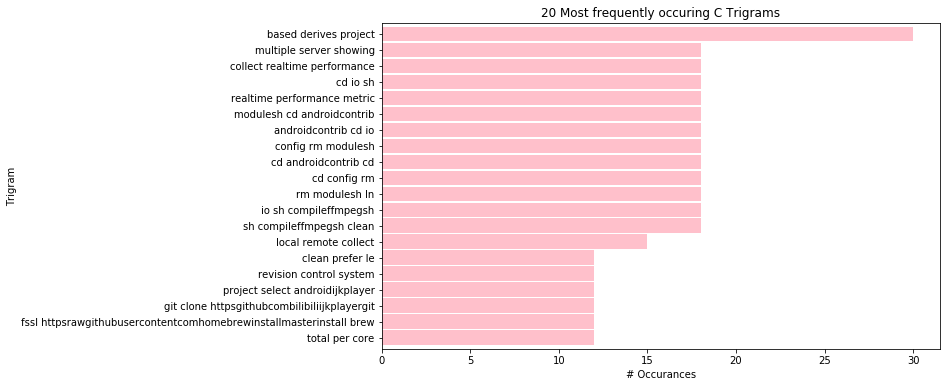

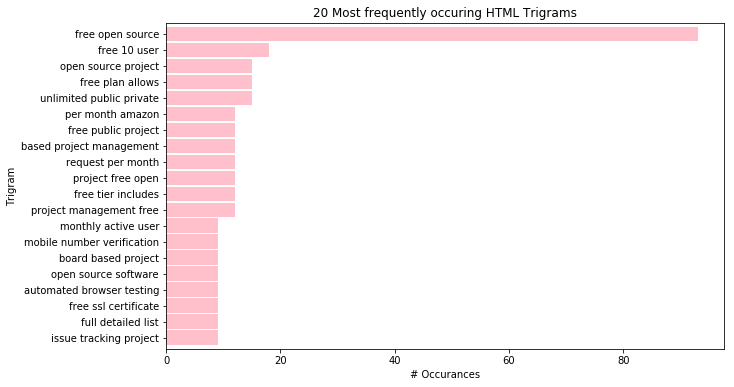

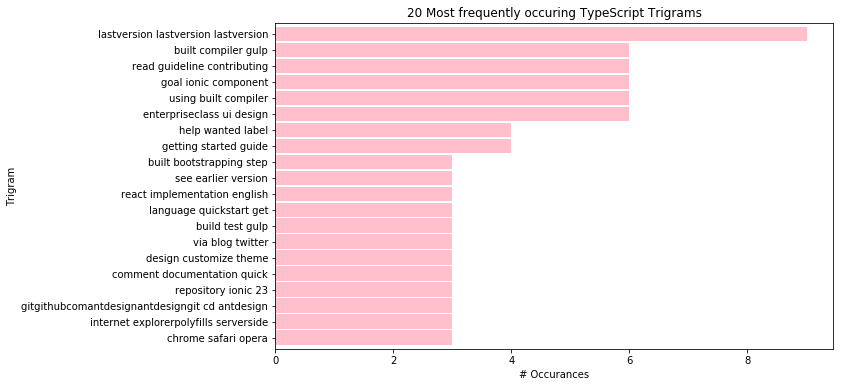

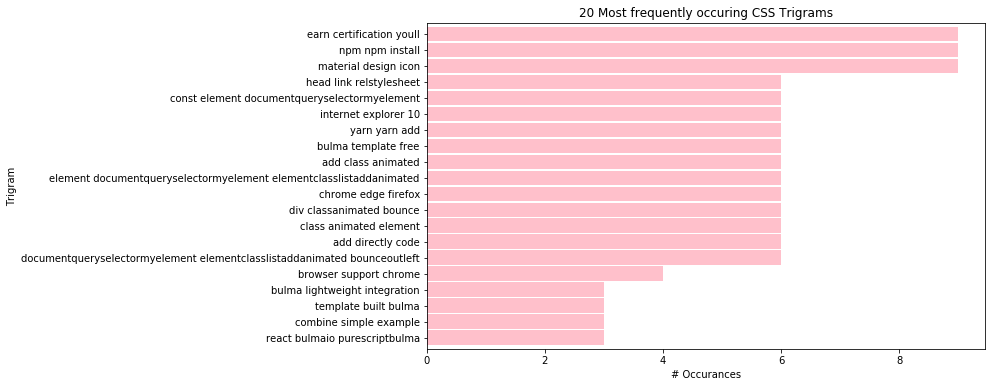

In [370]:
x=0
lang_words = [javascript_words, python_words, java_words, go_words, cpp_words, c_words, html_words, 
          typescript_words, css_words]
lang_list = ['JavaScript', 'Python', 'Java', 'Go', 'C++', 'C', 'HTML', 'TypeScript', 'CSS']

for i in lang_words:
    gram = (pd.Series(nltk.ngrams(i.split(), 3))
                          .value_counts()
                          .head(20))
    l = lang_list
    gram.head()

    gram.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))
    
    
    plt.title(f'20 Most frequently occuring {l[x]} Trigrams')
    x += 1
    plt.ylabel('Trigram')
    plt.xlabel('# Occurances')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = gram.reset_index().sort_values(by=0)['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
    _ = plt.yticks(ticks, labels)
    plt.show()

In [371]:
top_20_javascript_bigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 2))
                      .value_counts()
                      .head(20))

top_20_javascript_bigrams.head()

(source, code)     2035
(react, native)    2012
(back, top)        1366
(demo, source)      567
(code, mit)         483
dtype: int64

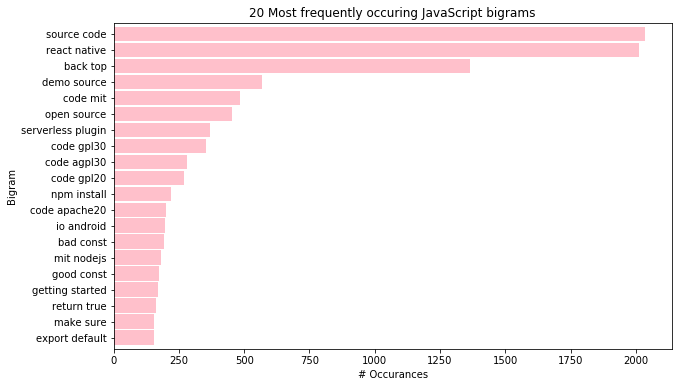

In [372]:
top_20_javascript_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_javascript_bigrams.reset_index().sort_values(by=0)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

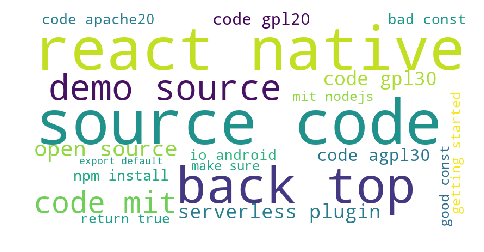

In [373]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_javascript_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [374]:
top_20_javascript_trigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 3))
                      .value_counts()
                      .head(20))

top_20_javascript_trigrams.head()

(demo, source, code)      567
(source, code, mit)       471
(source, code, gpl30)     354
(source, code, agpl30)    279
(source, code, gpl20)     270
dtype: int64

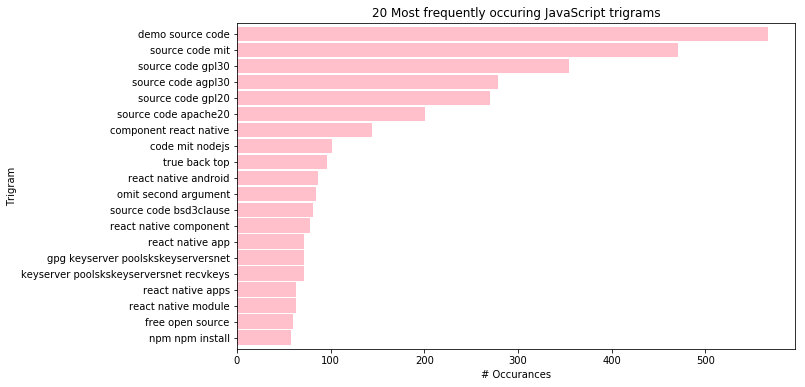

In [375]:
top_20_javascript_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_javascript_trigrams.reset_index().sort_values(by=0)['index'].\
apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

(-0.5, 799.5, 399.5, -0.5)

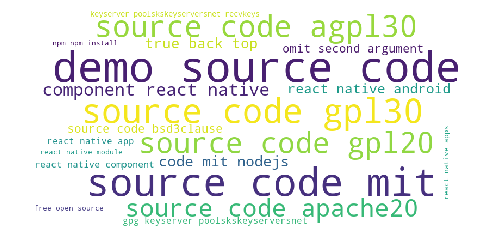

In [376]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_javascript_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

In [377]:
data

{'demo source code': 567,
 'source code mit': 471,
 'source code gpl30': 354,
 'source code agpl30': 279,
 'source code gpl20': 270,
 'source code apache20': 201,
 'component react native': 144,
 'code mit nodejs': 102,
 'true back top': 96,
 'react native android': 87,
 'omit second argument': 84,
 'source code bsd3clause': 81,
 'react native component': 78,
 'react native app': 72,
 'gpg keyserver poolskskeyserversnet': 72,
 'keyserver poolskskeyserversnet recvkeys': 72,
 'react native apps': 63,
 'react native module': 63,
 'free open source': 60,
 'npm npm install': 58}

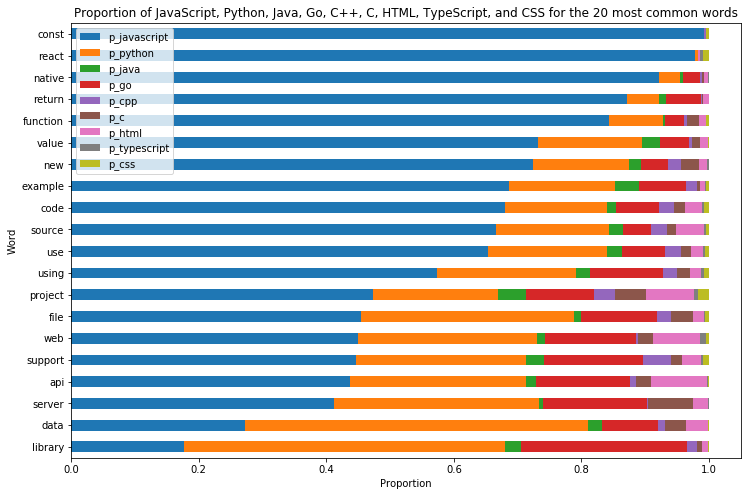

In [378]:
(word_counts
 .assign(p_javascript=word_counts.javascript / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.java / word_counts['all'],
         p_go=word_counts.go / word_counts['all'],
         p_cpp=word_counts.cpp / word_counts['all'],
         p_c=word_counts.c / word_counts['all'],
         p_html=word_counts.html / word_counts['all'],
         p_typescript=word_counts.typescript / word_counts['all'],
         p_css=word_counts.css / word_counts['all'])
 .sort_values(by='all')
 [['p_javascript', 'p_python', 'p_java', 'p_go', 'p_cpp', 'p_c', 'p_html', 'p_typescript', 'p_css']]
 .tail(20)
 .sort_values('p_javascript')
 .plot.barh(stacked=True, figsize=(12, 8)))

plt.ylabel('Word')
plt.xlabel('Proportion')
plt.title('Proportion of JavaScript, Python, Java, Go, C++, C, HTML, TypeScript, and CSS for the 20 most common words')
plt.show()

In [379]:
words_by_language = [javascript_words, python_words, java_words, go_words,
                     cpp_words, c_words, html_words, typescript_words, css_words]
language_names = ['javascript', 'python', 'java', 'go', 'cpp', 'c', 'html', 'typescript', 'css']

df3 = pd.DataFrame(dict(language = language_names, words = words_by_language))

# MODEL

In [380]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [381]:
tfidf = TfidfVectorizer()

tfidfs = tfidf.fit_transform(df2.stemmed)
tfidfs

# run at your own risk
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

,00,000,0000,00000,000000,00008080,00008080ping,00008787,0000ff,0001,...,zu,zulip,zurb,zweig,zxf,zydi,zynga,zypper,zyszi,zyszys98gmailcom
0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.030734,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.000000,0.000000,0.0,0.030734,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [382]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df2.stemmed)
y = df2.language
y.value_counts()

JavaScript    294
Python         95
Java           58
Go             46
C++            38
C              23
HTML           23
TypeScript     17
CSS            16
Name: language, dtype: int64

In [383]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=142348)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(solver='newton-cg',
                       multi_class='multinomial').fit(X_train, y_train)

train['lr_predicted'] = lm.predict(X_train)
test['lr_predicted'] = lm.predict(X_test)

In [384]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(lm.score(X_train, y_train)))

print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(lm.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on training set: 0.92
Accuracy of Logistic Regression classifier on test set: 0.84


In [385]:
# decision tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree

# data modeling
import graphviz
from graphviz import Graph

# usage example:
clf = tree.DecisionTreeClassifier(max_depth=6, criterion='gini')
clf = clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render('DF_tree', view=True)

train['dt_predicted'] = clf.predict(X_train)
test['dt_predicted'] = clf.predict(X_test)

print('Accuracy of decision tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print('Accuracy of decision tree classifier on training set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of decision tree classifier on training set: 0.78
Accuracy of decision tree classifier on training set: 0.73


In [386]:
# random forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=12, 
                            random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.83
Accuracy of random forest classifier on training set: 0.77


In [139]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           C       1.00      0.17      0.29         6
         C++       1.00      0.44      0.62         9
         CSS       0.00      0.00      0.00         4
          Go       1.00      0.50      0.67        12
        HTML       1.00      0.33      0.50         6
        Java       1.00      0.43      0.60        14
  JavaScript       0.62      1.00      0.77        70
      Python       1.00      0.75      0.86        24
  TypeScript       0.00      0.00      0.00         4

   micro avg       0.72      0.72      0.72       149
   macro avg       0.74      0.40      0.48       149
weighted avg       0.77      0.72      0.68       149



In [140]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.53


In [126]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.dt_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.dt_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.dt_predicted))

Accuracy: 83.22%
---
Confusion Matrix
actual        C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
dt_predicted                                                             
C             6    0    0   0     0     0           0       0           0
C++           0    6    0   0     0     4           0       0           0
CSS           0    0    2   0     0     0           0       0           0
Go            0    0    1  12     0     2           2       1           0
HTML          0    0    1   0     6     0           0       0           0
Java          0    0    0   0     0     2           0       0           0
JavaScript    0    1    0   0     0     3          68       4           1
Python        0    2    0   0     0     3           0      19           0
TypeScript    0    0    0   0     0     0           0       0           3
---
              precision    recall  f1-score   support

           C       1.00      1.00      1.00         6
         C++       0.60      0.67  

In [127]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.dt_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.dt_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.dt_predicted))

Accuracy: 39.47%
---
Confusion Matrix
actual        C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
dt_predicted                                                             
C             1    0    0   0     0     0           0       0           0
C++           0    0    0   0     0     2           1       0           0
CSS           0    0    0   0     0     0           1       0           0
Go            0    1    0   0     0     0           0       0           0
HTML          0    0    0   0     0     0           1       0           0
JavaScript    0    1    1   2     1     1          13       4           0
Python        0    1    0   1     0     1           2       1           1
TypeScript    0    0    0   0     0     0           0       1           0
---
              precision    recall  f1-score   support

           C       1.00      1.00      1.00         1
         C++       0.00      0.00      0.00         3
         CSS       0.00      0.00      0.00         1
 

In [111]:
train.dt_predicted.value_counts()

JavaScript    70
Python        24
Java          14
Go            12
C++            9
HTML           6
C              6
CSS            4
TypeScript     4
Name: dt_predicted, dtype: int64

(38, 3)

In [103]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 60.40%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                              
Go          0    0    0   2     0     0           0       0           0
Java        0    0    0   0     0     6           0       0           0
JavaScript  6    9    4  10     6     8          70      12           4
Python      0    0    0   0     0     0           0      12           0
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         6
         C++       0.00      0.00      0.00         9
         CSS       0.00      0.00      0.00         4
          Go       1.00      0.17      0.29        12
        HTML       0.00      0.00      0.00         6
        Java       1.00      0.43      0.60        14
  JavaScript       0.54      1.00      0.70        70
      Python       1.00      0.50      0.67        24
  TypeScript       0.00      0.00      

Predict language from readme function

In [387]:
def predict_lang(text):
    return lm.predict(tfidf.transform([text]))[0]

In [393]:
predict_lang('animatecss github releasehttpsimgshieldsiogithubreleasedanedenanimatecsssvghttpsgithubcomdanedenanimatecssrelease cdnjshttpsimgshieldsiocdnjsvanimatecsssvghttpscdnjscomlibrariesanimatecs build statushttpstraviscicomdanedenanimatecsssvgbranchmasterhttpstraviscicomdanedenanimatecss devdependencie statushttpsdaviddmorgdanedenanimatecssdevstatussvghttpsdaviddmorgdanedenanimatecsstypedev chathttpsimgshieldsiobadgechatgittergreensvghttpsgitterimanimatecsslobby npm versionhttpsbadgefuryiojsanimatecsssvghttpswwwnpmjscompackageanimatecss justaddwater css animation animatecs bunch cool fun crossbrowser animation use project great emphasis home page slider general justaddwaterawesomeness installation install via npm bash npm install animatecs save yarn bash yarn add animatecs usage use animatecs website simply drop stylesheet document head add class animate element along animation name get css animate element super html head link relstylesheet hrefanimatemincs head use cdn host version cdnjshttpscdnjscomlibrariesanimatecss html head link relstylesheet hrefhttpscdnjscloudflarecomajaxlibsanimatecss370animatemincs head animation animate element add class animate element include class infinite infinite loop finally need add one follow class element class name bounce flash pulse rubberband shake headshake swing tada wobble jello bouncein bounceindown bounceinleft bounceinright bounceinup bounceout bounceoutdown bounceoutleft bounceoutright bounceoutup fadein fadeindown fadeindownbig fadeinleft fadeinleftbig fadeinright fadeinrightbig fadeinup fadeinupbig fadeout fadeoutdown fadeoutdownbig fadeoutleft fadeoutleftbig fadeoutright fadeoutrightbig fadeoutup fadeoutupbig flipinx flipiny flipoutx flipouty lightspeedin lightspeedout rotatein rotateindownleft rotateindownright rotateinupleft rotateinupright rotateout rotateoutdownleft rotateoutdownright rotateoutupleft rotateoutupright hinge jackinthebox rollin rollout zoomin zoomindown zoominleft zoominright zoominup zoomout zoomoutdown zoomoutleft zoomoutright zoomoutup slideindown slideinleft slideinright slideinup slideoutdown slideoutleft slideoutright slideoutup heartbeat full example html h1 classanimate infinite bounce delay2sexampleh1 check animation herehttpsdanedengithubioanimatecs possible change duration animation add delay change number time play css yourelement animationduration 3s animationdelay 2s animationiterationcount infinite usage javascript whole bunch stuff animatecs combine javascript simple example javascript const element documentqueryselectormyelement elementclasslistaddanimated bounceoutleft also detect animation end javascript const element documentqueryselectormyelement elementclasslistaddanimated bounceoutleft elementaddeventlisteneranimationend function dosomethe use simple function add remove animation javascript function animatecsselement animationname callback const node documentqueryselectorelement nodeclasslistaddanimat animationname function handleanimationend nodeclasslistremoveanimated animationname noderemoveeventlisteneranimationend handleanimationend typeof callback function callback nodeaddeventlisteneranimationend handleanimationend use like javascript animatecssmyelement bounce animatecssmyelement bounce function something animation notice example use es6 const declaration drop support ie10 age browser prefer switch const var declaration ie10 old browser get support still provide classlisthttpsdevelopermozillaorgenusdocswebapielementclasslist support researchhttpscaniusecomfeatclasslist set delay speed delay class possible add delay directly element class attribute like html div classanimate bounce delay2sexamplediv class name delay time delay2s 2s delay3s 3s delay4s 4s delay5s 5s note default delay 1 second 5 second need custom delay add directly css code slow slow fast fast class possible control speed animation add class sample html div classanimate bounce fasterexamplediv class name speed time slow 2s slow 3s fast 800m fast 500ms note animate class default speed 1 need custom duration add directly css code custom build animatecs power gulpjshttpgulpjscom mean create custom build pretty easily first need gulp dependency sh cd pathtoanimatecs sudo npm install next run gulp compile custom build example want attention seeker simply edit animateconfigjson file select animation want use javascript attentionseeker bounce true flash false pulse false shake true headshake true swe true tada true wobble true jellotrue accessibility animatecs support prefersreducedmotion medium queryhttpswebkitorgblog7551responsivedesignformotion user motion sensitivity opt animation support platform currently firefox osx safari ios safari user select reduce motion operating system preference turn css transition without work require license animatecs license mit license httpopensourceorglicensesmit code conduct project everyone participate govern contributor covenant code conductcodeofconductmd participate expect uphold code please report unacceptable behavior callmeeltongmailcommailtocallmeeltongmailcom contribute pull request way go two rule submit pull request match naming convention camelcase categorise fade bounce etc let see demo submit animation penhttpcodepenio last one important')

'JavaScript'